
**Camélia HELAL** - A4SYS - 2025/2026

Ma412 - Data science & Decision-making
# Machine Learning Project : Predicting Team Performance at the FIFA Women's World Cup

**Objective of the project**  
The goal of this mini-project is to apply **Machine Learning** to a 
dataset inspired by the **FIFA Women's World Cup**.  
We imagine that, before each World Cup, a football federation wants to estimate how far its
national team can go in the tournament, based on several pre-tournament indicators (FIFA ranking, goals scored and conceded, possession, etc...)

More concretely, we will :

1. Load a dataset from `womens_world_cup_synthetic.mat` file and understand its structure.
2. Perform **exploratory data analysis (EDA)** and basic preprocessing.
3. Train and compare several **classification models**.
4. Evaluate the models using appropriate **metrics and visualizations**.
5. Interpret the results with simple explainability tools (feature importance).
6. Provide **decision support** recommendations based on the analysis.

> The dataset used here is **synthetic** (generated to look realistic) because collecting and cleaning real match data would take a lot of time.
> However, the **machine learning workflow** is exactly the same as for a real project.


## 1. Importing libraries and utility functions

In [1]:

# Standard numerical and data analysis libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.inspection import permutation_importance

# Functions (in utils.py)
from utils import *

#(load_data,split_and_scale,plot_confusion_matrix,plot_multiclass_roc,plot_feature_importances)

# Better plots 
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)

# For reproducibility 
RANDOM_STATE = 42


## 2. Loading the FIFA Women’s World Cup dataset

In [2]:

mat_path = "womens_world_cup_synthetic.mat"
# Function defined in utils.py
X, y, feature_names = load_data(mat_path)

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)
print("\nFeature names :\n", feature_names)

# Build a Pandas DataFrame
df = pd.DataFrame(X, columns=feature_names)
df["stage_reached"] = y

df.head()


Shape of X (features): (96, 8)
Shape of y (target): (96,)

Feature names :
 ['FIFA_rank' 'avg_goals_scored' 'avg_goals_conceded'
 'total_shots_per_game' 'possession_pct' 'pass_accuracy_pct' 'host_nation'
 'confed_code']


,FIFA_rank,avg_goals_scored,avg_goals_conceded,total_shots_per_game,possession_pct,pass_accuracy_pct,host_nation,confed_code,stage_reached
0,5.0,2.21,0.00,8.8,52.3,72.8,0.0,2.0,3
1,39.0,1.76,1.36,10.9,42.3,80.4,0.0,1.0,0
2,33.0,2.08,0.71,9.5,46.6,77.3,1.0,1.0,1
3,22.0,1.65,0.95,12.6,54.5,68.8,1.0,4.0,1
4,22.0,1.80,0.83,6.0,61.2,82.6,0.0,3.0,1



## 3. Exploratory Data Analysis

In this section, we try to understand what the variables represent and how they behave.


In [15]:

# Information about the dataset

print(" INFORMATION : \n")
print(df.info())

print("\n DESCRIPTIVE STATISTICS : ")
df.describe()


 INFORMATION : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FIFA_rank             96 non-null     float64
 1   avg_goals_scored      96 non-null     float64
 2   avg_goals_conceded    96 non-null     float64
 3   total_shots_per_game  96 non-null     float64
 4   possession_pct        96 non-null     float64
 5   pass_accuracy_pct     96 non-null     float64
 6   host_nation           96 non-null     float64
 7   confed_code           96 non-null     float64
 8   stage_reached         96 non-null     int64  
 9   stage_label           96 non-null     object 
dtypes: float64(8), int64(1), object(1)
memory usage: 7.6+ KB
None

 DESCRIPTIVE STATISTICS : 


,FIFA_rank,avg_goals_scored,avg_goals_conceded,total_shots_per_game,possession_pct,pass_accuracy_pct,host_nation,confed_code,stage_reached
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,27.072917,1.544271,1.172500,13.272917,51.753125,78.057292,0.479167,2.802083,1.031250
std,13.652256,0.617086,0.580455,4.078841,8.104774,5.141815,0.502188,1.726693,1.060815
min,3.000000,0.390000,0.000000,5.000000,33.300000,63.200000,0.000000,0.000000,0.000000
25%,17.000000,1.147500,0.760000,10.650000,46.550000,74.925000,0.000000,1.000000,0.000000
50%,26.500000,1.500000,1.115000,13.100000,53.000000,77.950000,0.000000,3.000000,1.000000
75%,39.000000,1.942500,1.462500,15.925000,57.700000,81.150000,1.000000,4.000000,2.000000
max,49.000000,3.640000,2.710000,24.600000,70.000000,90.000000,1.000000,5.000000,3.000000


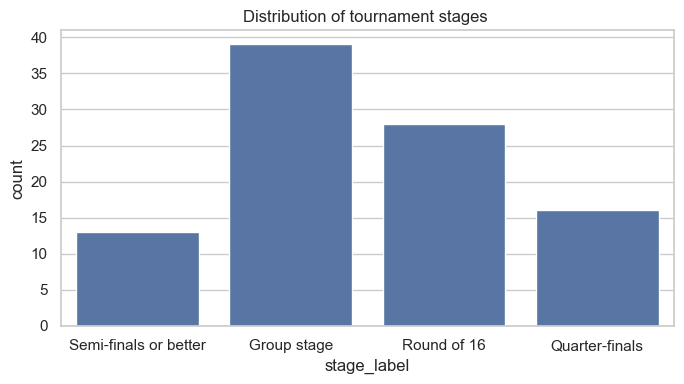

In [4]:

# Distribution of the target variable 
stage_mapping = {
    0: "Group stage",
    1: "Round of 16",
    2: "Quarter-finals",
    3: "Semi-finals or better"}

df["stage_label"] = df["stage_reached"].map(stage_mapping)
stage_counts = df["stage_label"].value_counts().sort_index()
stage_counts

# Plot the distribution of the tournament stages
sns.countplot(x="stage_label", data=df)
plt.title("Distribution of tournament stages ")
plt.tight_layout()
plt.show()


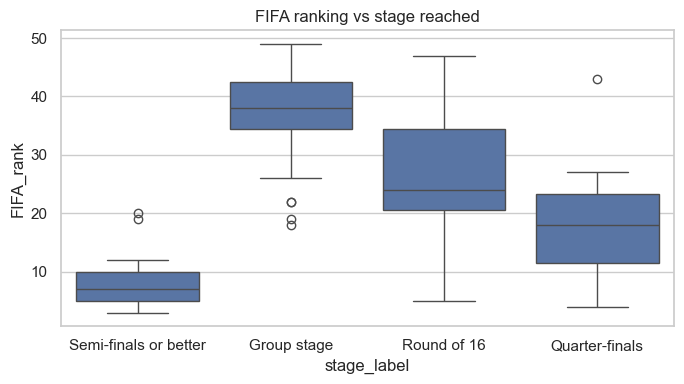

In [5]:

# Relationship between FIFA ranking and stage reached
sns.boxplot(x="stage_label", y="FIFA_rank", data=df)
plt.title("FIFA ranking vs stage reached")
plt.tight_layout()
plt.show()


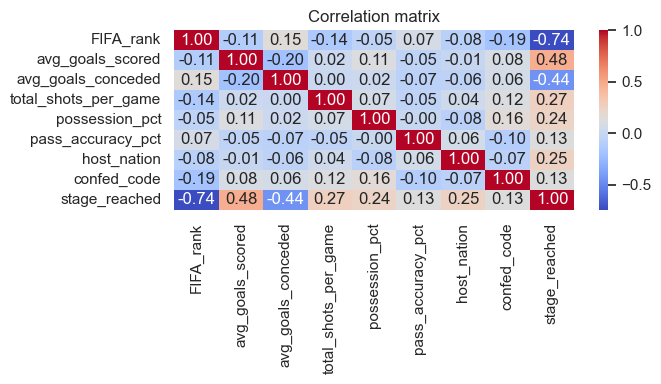

In [6]:

# Correlation matrix between features
num_cols = feature_names
corr = df[num_cols.tolist() + ["stage_reached"]].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()



## 4. Data preprocessing and train/validation/test split

We now prepare the data for machine learning:

1. We split the dataset into **train**, **validation** and **test** sets.
2. We standardize the features (zero mean, unit variance) so that models like
   k-nearest neighbors and logistic regression behave correctly.


In [7]:

# Separate features (X) and target (y)
X = df[feature_names].values
y = df["stage_reached"].values

# Split and scale 
X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale(
    X, y, test_size=0.2, val_size=0.2, random_state=RANDOM_STATE)

print("Training set size :", X_train.shape)
print("Validation set size :", X_val.shape)
print("Test set size :", X_test.shape)


Training set size : (57, 8)
Validation set size : (19, 8)
Test set size : (20, 8)



## 5. Training and comparing several models

We compare three classic supervised learning algorithms for multi-class classification :

1. **Logistic Regression** (multinomial)
2. **Random Forest** (ensemble of decision trees)
3. **k-Nearest Neighbors (k-NN)**

For each model we compute :

- Accuracy
- Macro-averaged precision, recall and F1-score


**Parameters**
- model : Classifier with fit / predict methods
- X_tr : Training features
- y_tr : Training labels
- X_val : Validation features
- y_val : Validation labels model_name


In [8]:

def evaluate_model(model, X_tr, y_tr, X_val, y_val, model_name="model"):
    
    # Fit the model
    model.fit(X_tr, y_tr)
    # Predict on the validation set
    y_pred = model.predict(X_val)

    # Compute evaluation metrics
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)

    print(f"{model_name} \n - Accuracy : {acc:.3f}\n - F1-score : {f1:.3f}\n")
    return {"model_name": model_name,"model": model,"accuracy": acc,"f1_macro": f1,}

results = []


# Tests 

models = [
    ("Logistic Regression", LogisticRegression(max_iter=500, random_state=RANDOM_STATE)),
    ("Random Forest", RandomForestClassifier(random_state=RANDOM_STATE)),
    ("k-Nearest Neighbors (k=7)", KNeighborsClassifier(n_neighbors=7))
]

results = []
for name, model in models:
    results.append(evaluate_model(model, X_train, y_train, X_val, y_val, name))
 

Logistic Regression 
 - Accuracy : 0.789
 - F1-score : 0.764

Random Forest 
 - Accuracy : 0.579
 - F1-score : 0.419

k-Nearest Neighbors (k=7) 
 - Accuracy : 0.632
 - F1-score : 0.601




## 6. Final evaluation on the test set

We select the model with the best validation **F1-score** and evaluate it on the
held-out **test set**, which simulates new, unseen World Cup tournaments.

We also visualize:

- The **confusion matrix** (where the model makes mistakes).

In [10]:

# Select the best model (highest F1 score)
best_result = max(results, key=lambda d: d["f1_macro"])
best_model = best_result["model"]
best_name = best_result["model_name"]
print(f"Best model according to validation F1-score : {best_result['model_name']}")

# Retrain with all available data (train + validation)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])
best_model.fit(X_train_full,y_train_full)

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print("\nTest set performance : \n")
print(classification_report(y_test, y_pred))


Best model according to validation F1-score : Logistic Regression

Test set performance : 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.80      0.67      0.73         6
           2       1.00      0.67      0.80         3
           3       1.00      1.00      1.00         3

    accuracy                           0.85        20
   macro avg       0.90      0.83      0.85        20
weighted avg       0.86      0.85      0.84        20



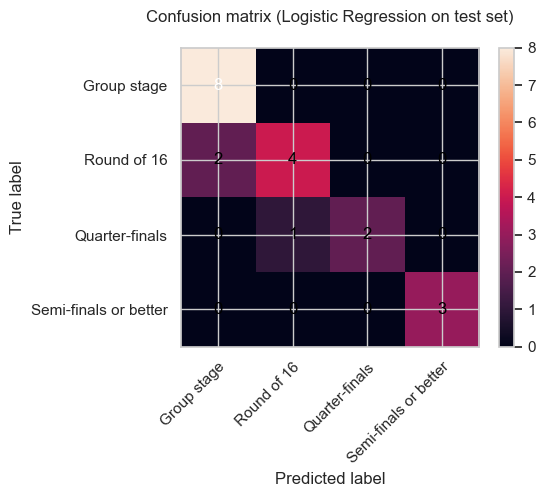

In [11]:
 
# Confusion matrix on the test set
class_names = list(stage_mapping.values())
plot_confusion_matrix(
    y_test, y_pred, 
    class_names=class_names,
    title=f"Confusion matrix ({best_name} on test set)\n")



## 7. Model interpretation (feature importance)

To make the model useful for coaches and analysts, we need to understand **why** it predicts
a certain stage. We focus on two simple (but informative) tools :

- **Feature importances** (for the Random Forest model).
- **Permutation importance** (impact of shuffling a feature on model performance).


Training RandomForest for feature importance analysis


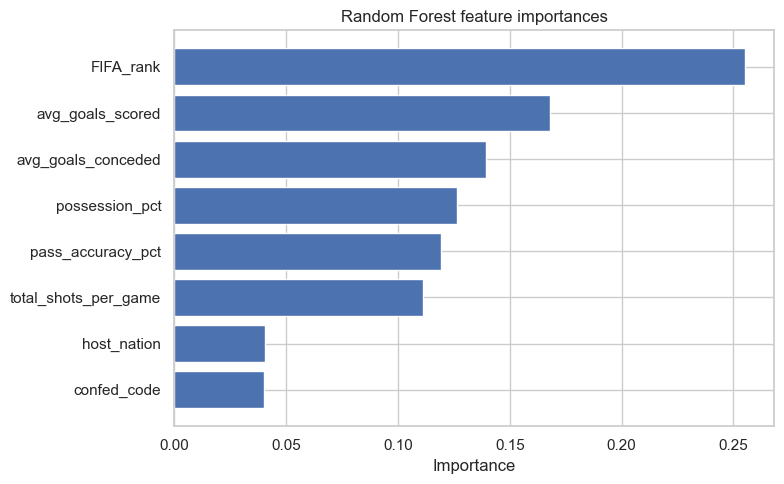

In [12]:

# If best model isn't RandomForest, train one anyway
if not isinstance(best_model, RandomForestClassifier):
    print("Training RandomForest for feature importance analysis")
    rf = RandomForestClassifier(random_state=RANDOM_STATE)
    rf.fit(X_train_full, y_train_full)
else:
    rf = best_model

# Plot feature importances
plot_feature_importances(feature_names, rf.feature_importances_,
    top_k=len(feature_names),title="Random Forest feature importances")


In [13]:

# Permutation importance of each feature on the test set
perm_result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    scoring="f1_macro"
)

perm_importances = perm_result.importances_mean
perm_df = pd.DataFrame({
    "feature": feature_names,
    "permutation_importance": perm_importances
}).sort_values(by="permutation_importance", ascending=False)

perm_df


,feature,permutation_importance
0,FIFA_rank,0.360291
1,avg_goals_scored,0.296554
2,avg_goals_conceded,0.222007
6,host_nation,0.185534
5,pass_accuracy_pct,0.165874
4,possession_pct,0.078727
3,total_shots_per_game,0.057789
7,confed_code,0.000000


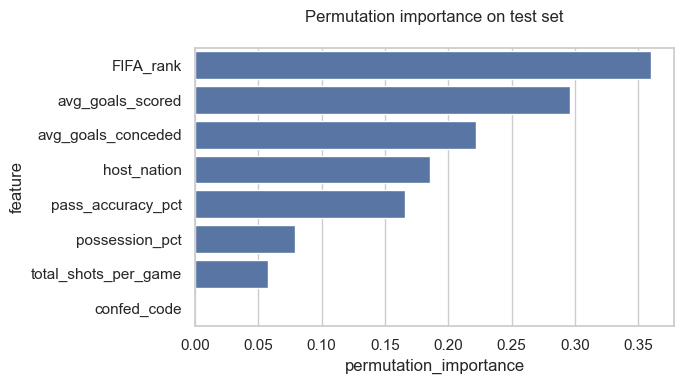

In [14]:

# Plot permutation importance as a bar chart
sns.barplot(x="permutation_importance", y="feature", data=perm_df)
plt.title("Permutation importance on test set\n")
plt.tight_layout()
plt.show()



## 8. Decision support : How can a federation use these results ?

From the previous analyses, we can extract several **practical recommendations** for
a national federation preparing the FIFA Women's World Cup :

- **FIFA ranking and offensive power matter a lot**  
  Better-ranked teams with higher average goals scored and more shots per game are much
  more likely to reach the quarter-finals or semi-finals.  

- **Defensive solidity is also important**  
  Teams that concede fewer goals on average are more stable over the full competition.  

- **Ball possession and passing accuracy**  
  In our model, good possession and passing accuracy are correlated with better stages.  

- **Host nation advantage**  
  Being the host nation slightly increases the probability of reaching the knockout stage.


## **Conclusion**
In a real project, the federation could **retrain this model** regularly with fresh data
from all international matches. Before the World Cup draw, the staff could :

1. Estimate the current features of their team (goals, possession, etc.).  
2. Use the model to compute the probability of each World Cup stage.  
3. Decide on **priorities for player selection**, focusing on the
   features that the model ranks as most important.
